# Kütüphanelerimizi import ediyoruz.

In [83]:
import json, sys, random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks

In [84]:
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import requests
import os


Daha önceden işaretlenmiş verilerimizi içeren json dosyamızı import ediyoruz

In [85]:
# İndirdiğimiz datasetin içerisinde labellerin ve vektörlerin yer aldığı json dosyamızı import edelim
f = open('shipsnet.json')
dataset = json.load(f)
f.close()

In [86]:
input_data = np.array(dataset['data']).astype('uint8')
output_data = np.array(dataset['labels']).astype('uint8')

Verilerimizi işlenmek için hazır hale getiriyoruz

In [87]:
# output 
y = np_utils.to_categorical(output_data, 2)

In [88]:
# Bütün indexleri karıştır
indexes = np.arange(4000)
np.random.shuffle(indexes)

In [89]:
X_train = X[indexes].transpose([0,2,3,1])
y_train = y[indexes]

In [90]:
X_train = X_train / 255

# Verilerimizi Eğitelim!

In [91]:
np.random.seed(42)


In [92]:
# Model Ağ Tasarımı
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [93]:
# Optimizasyon
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

# Eğit
model.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=18,
    validation_split=0.2,
    shuffle=True,
    verbose=2)

Train on 3200 samples, validate on 800 samples
Epoch 1/18
 - 22s - loss: 0.4191 - accuracy: 0.8172 - val_loss: 0.2425 - val_accuracy: 0.8963
Epoch 2/18
 - 22s - loss: 0.2474 - accuracy: 0.8975 - val_loss: 0.1873 - val_accuracy: 0.9350
Epoch 3/18
 - 22s - loss: 0.2060 - accuracy: 0.9153 - val_loss: 0.1516 - val_accuracy: 0.9425
Epoch 4/18
 - 22s - loss: 0.1714 - accuracy: 0.9316 - val_loss: 0.1044 - val_accuracy: 0.9675
Epoch 5/18
 - 22s - loss: 0.1370 - accuracy: 0.9469 - val_loss: 0.0747 - val_accuracy: 0.9762
Epoch 6/18
 - 23s - loss: 0.1243 - accuracy: 0.9566 - val_loss: 0.0964 - val_accuracy: 0.9775
Epoch 7/18
 - 22s - loss: 0.1116 - accuracy: 0.9584 - val_loss: 0.0913 - val_accuracy: 0.9663
Epoch 8/18
 - 23s - loss: 0.0965 - accuracy: 0.9647 - val_loss: 0.0664 - val_accuracy: 0.9750
Epoch 9/18
 - 23s - loss: 0.0749 - accuracy: 0.9734 - val_loss: 0.0626 - val_accuracy: 0.9812
Epoch 10/18
 - 23s - loss: 0.0714 - accuracy: 0.9753 - val_loss: 0.0481 - val_accuracy: 0.9850
Epoch 11/18


Verilerimizi eğittikten sonra image_count adında bir fonksiyon oluşturuyoruz. Bu fonksiyon klasörümüzde bulunan her fotoğraf için tek tek görüntü işleme fonksiyonlarını çalıştırarak sonuç elde edecek.

In [94]:
def image_count(dosyakonum):
    dosyalar=os.listdir(dosyakonum) #resimleri listele
    for i in range(len(dosyalar)): #resimleri tek tek aç
        try:
            image = Image.open(dosyakonum+dosyalar[i])
            pix = image.load()
            image_proccess(pix,image) #resim işleme fonksiyonuna gönder
        except:
            print("hebele")

Cutting fonksiyonumuz algılanan objenin sadece etrafını almamızı sağlıyor.

In [100]:
def cutting(picture_tensor,x, y): # algılanan gemiyi fotoğraftan kes
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

not_near fonksiyonumuz görsel içerisinde 10 adımda bir fotoğrafların pixellerini toplayarak içerisinde obje aramamızı sağlar.

In [96]:
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

show_ship fonksiyonumuz algılanan objenin etrafını kare olarak işaretler.

In [97]:
def show_ship(picture_tensor,x, y, acc, thickness=5):  #geminin etrafını çiz
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

image_roccess fonksiyonu aslında ana fonksiyonumuzdur. image_count dışındaki bütün fonksiyonları çalıştırarak görüntü üzerinde işlemler yapmamızı sağlar.

In [98]:
def image_proccess(pix,image):
    n_spectrum = 3
    width = image.size[0]
    height = image.size[1]
    # vektör oluştur
    picture_vector = []
    for chanel in range(n_spectrum):
        for y in range(height):
            for x in range(width):
                picture_vector.append(pix[x, y][chanel])
    picture_vector = np.array(picture_vector).astype('uint8')
    picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)
    picture_tensor.shape
    plt.figure(1, figsize = (15, 30))

    plt.subplot(3, 1, 1)
    

    picture_tensor = picture_tensor.transpose(2,0,1)
    picture_tensor.shape
    
    step = 10; coordinates = []
    for y in range(int((height-(80-step))/step)):
        for x in range(int((width-(80-step))/step) ):
            area = cutting(picture_tensor,x*step, y*step)
            result = model.predict(area)
            if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
                coordinates.append([[x*step, y*step], result])
                for e in coordinates:
                    show_ship(picture_tensor,e[0][0], e[0][1], e[1][0][1])
                picture_tensor = picture_tensor.transpose(1,2,0)
                picture_tensor.shape
                plt.figure(1, figsize = (15, 30))
                plt.subplot(3,1,1)
                plt.imshow(picture_tensor)
                plt.show()

Görüntülerimizin konumunu belirterek yazılımımızı çalıştırıyoruz. Ve sonuçlar aşağıda göründüğü gibidir.

X:20 Y:140   

c:\users\menta\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


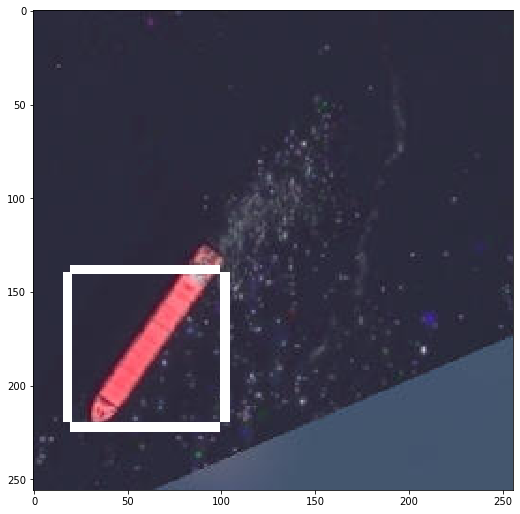

hebele
X:70 Y:150   

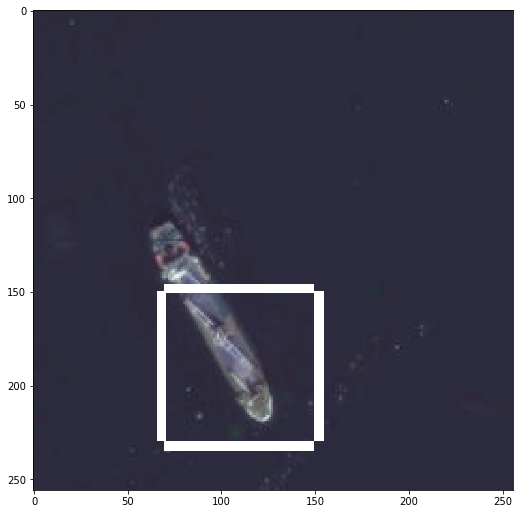

hebele
X:130 Y:30  

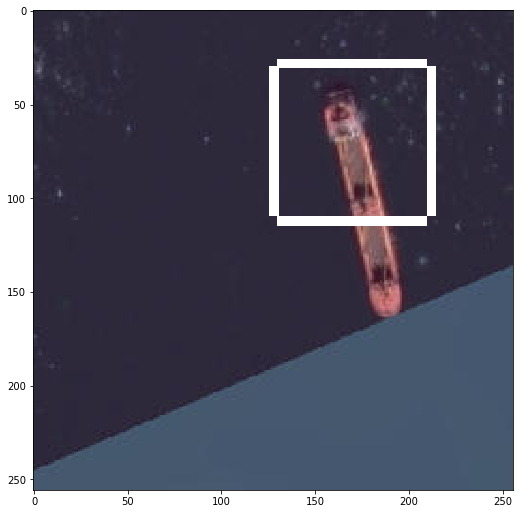

hebele


In [99]:
konum = "C:/Users/menta/Desktop/bimtaş/shipsnet/Untitled Folder/photos/"
image_count(konum)
